# Avellaneda-Stoikov

In [1]:
import sys
sys.path.append("../") # This version of the notebook is in the subfolder "notebooks" of the repo

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy

from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.Traders import AmmTrader

from mbt_gym.agents.BaselineAgents import *
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.helpers.plotting import *
from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import CjCriterion, CjMmCriterion
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.stochastic_processes.arrival_models import *
import torch
#print(torch.cuda.is_available())
#print(torch.cuda.get_device_name())

## Avellaneda-Stoikov Optimal Strategy

In [6]:
terminal_time = 1.0
arrival_rate = 50.0
n_steps = int(10 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001
seed = 1
num_trajectories = 1

In [7]:
def get_amm_env_Poisson(num_trajectories:int = 1):    
    fill_exponent = 1
    sigma = 0.001
    initial_inventory = 100
    initial_price = 100
    unit_size = 1
    max_depth = 5*1/fill_exponent
    step_size = terminal_time/n_steps
    midprice_model = AmmSelfContainedMidpriceModel(jump_size_L=1.0, 
                                                   unit_size = unit_size,
                                                   terminal_time=terminal_time, 
                                                       step_size=step_size, 
                                                       initial_price=initial_price, 
                                                       num_trajectories=num_trajectories, seed = seed)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), step_size=step_size, seed = seed)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories, seed = seed)
    AMMtrader = AmmTrader(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories, max_depth = max_depth, unit_size = unit_size)
    
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      midprice_model = midprice_model,
                      arrival_model = arrival_model,
                      fill_probability_model = fill_probability_model,
                      trader = AMMtrader,
                      reward_function = CjMmCriterion(phi, alpha),
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [8]:
amm_env = get_amm_env_Poisson()
as_agent = FayLeoMmAgent(env=amm_env)

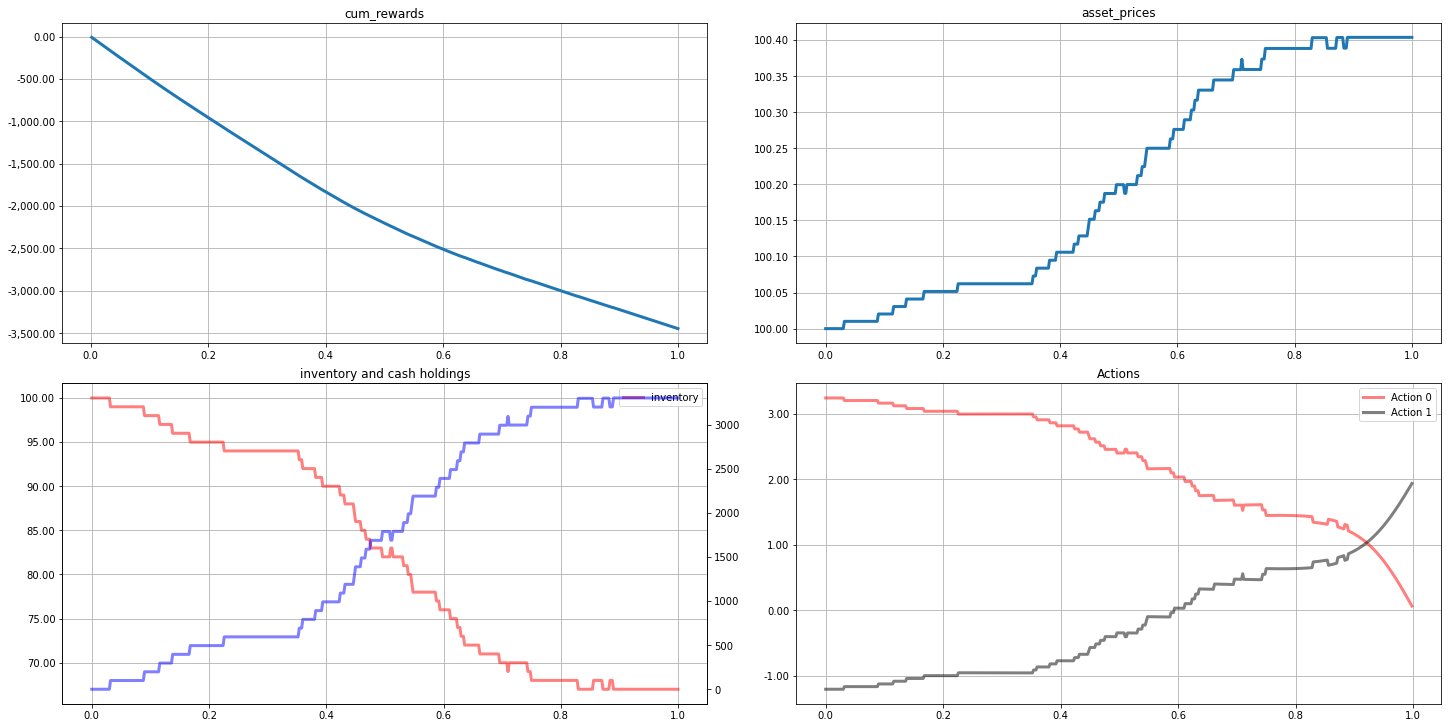

In [9]:
plot_trajectory(amm_env, as_agent, seed = seed)

### Comparing the results to the Avellaneda Stoikov paper

In [ ]:
num_trajectories = 100000
vec_env = get_as_env(num_trajectories)
vec_as = AvellanedaStoikovAgent(risk_aversion=0.1, env=vec_env)

In [ ]:
observations, actions, rewards = generate_trajectory(vec_env, vec_as)

In [ ]:
results, fig, total_rewards = generate_results_table_and_hist(vec_env=vec_env,agent=vec_as)

In [ ]:
results

These results look similar to Table 2 of Avellaneda and Stoikov. It is interesting that the agent **does** quote a negative spread sometimes, which _could_ be interpreted as taking liquidity but then the model should possibly be changed.

In [ ]:
fig

### The effect of increasing risk aversion

In [ ]:
risk_aversions = [0.01,0.1,0.5,1]

In [ ]:
total_rewards_dict = dict()
for risk_aversion in risk_aversions:
    vec_as = AvellanedaStoikovAgent(risk_aversion=risk_aversion, env=vec_env)
    _,_,total_rewards_dict[risk_aversion] = generate_results_table_and_hist(vec_env=vec_env,agent=vec_as);   

In [ ]:
colors = ["r", "g", "b", "c"]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
for risk_aversion, color in zip(risk_aversions,colors):
    sns.histplot(total_rewards_dict[risk_aversion], label=f"risk-aversion {risk_aversion}", stat = "density", bins = 50, ax=ax, color=color)
ax.legend()
plt.show()

**Note, it is hard to argue that the risk-averse agent is outperforming the non risk-averse agent in these cases...**

## The Cartea-Jaimungal agent

In [ ]:
cj_agent = CarteaJaimungalAgent(phi=0.1, alpha=0.001,env=as_env, max_inventory=100)

In [ ]:
plot_trajectory(as_env, cj_agent, seed = seed)